# **Multi-Agent LLM System for Academic Graph Exploration**

# Step 0: Package Installation & setup

In [1]:
!pip install udocker
!udocker --allow-root install
# udocker --allow-root run -p 8529:8529 -e ARANGO_ROOT_PASSWORD=openSesame arangodb/arangodb:3.12.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.6/119.6 kB 4.3 MB/s eta 0:00:00
Info: creating repo: /root/.udocker
Info: udocker command line interface 1.3.17
Info: searching for udockertools >= 1.2.11
Info: installing udockertools 1.2.11
Info: installation of udockertools successful


In [2]:
!pip install nx-arangodb
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com # Requires CUDA-capable GPU
!pip install --upgrade langchain langchain-community langchain-openai langgraph langgraph-prebuilt

!nvidia-smi
!nvcc --version

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 whic

In [3]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re
from google.colab import drive
import os
import polars as pl
from tqdm import tqdm

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

import requests
import os
from typing import Dict, Any, Optional
from IPython.display import display, Markdown
import pickle

[05:41:35 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [4]:
drive.mount('/content/drive')

os.environ["DATABASE_HOST"] = "http://localhost:8529"
os.environ["DATABASE_USERNAME"] = "root"
os.environ["DATABASE_PASSWORD"] = "openSesame"
os.environ["DATABASE_NAME"] = "_system"

Mounted at /content/drive


In [27]:
OPENAI_API_KEY = "YOUR_KEY"
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
WD_DATA = 'drive/MyDrive/COMPETITIONS/graphrag/data'

# Step 1: Choose & prepare your dataset for NetworkX

In this section I preprocess and filter original datasets, here I only
focus on papers from the sub-field "Artificial Intelligence".

The data is available using the link: https://springernature.figshare.com/collections/SciSciNet_A_large-scale_open_data_lake_for_the_science_of_science_research/6076908/1


In [ ]:
# Transform data to parquet format
data_paper_author_affiliations = pl.scan_csv(os.path.join(WD_DATA, "SciSciNet_PaperAuthorAffiliations.tsv"), separator="\t")
data_paper_author_affiliations.sink_parquet(os.path.join(WD_DATA, "data_paper_author_affiliations.parquet"))

data_paper_fields = pl.scan_csv(os.path.join(WD_DATA, "SciSciNet_PaperFields.tsv"), separator="\t")
data_paper_fields.sink_parquet(os.path.join(WD_DATA, "data_paper_fields.parquet"))

data_paper_details = pl.scan_csv(os.path.join(WD_DATA, "SciSciNet_PaperDetails.tsv"), separator="\t", dtypes={"FirstPage": pl.Utf8, "LastPage": pl.Utf8})
data_paper_details.sink_parquet(os.path.join(WD_DATA, "data_paper_details.parquet"))

data_authors = pl.scan_csv(os.path.join(WD_DATA, "SciSciNet_Authors.tsv"), separator="\t")
data_authors.sink_parquet(os.path.join(WD_DATA, "data_authors.parquet"))

data_affiliations = pl.scan_csv(os.path.join(WD_DATA, "SciSciNet_Affiliations.tsv"), separator="\t")
data_affiliations.sink_parquet(os.path.join(WD_DATA, "data_affiliations.parquet"))

data_journals = pl.scan_csv(os.path.join(WD_DATA, "SciSciNet_Journals.tsv"), separator="\t")
data_journals.sink_parquet(os.path.join(WD_DATA, "data_journals.parquet"))

In [ ]:
# Select only papers about "Artificial intelligence".
data_paper_fields = pl.scan_parquet(os.path.join(WD_DATA, "data_paper_fields.parquet"))
data_fields = pl.scan_parquet(os.path.join(WD_DATA, "data_fields.parquet"))

filtered_data_fields = data_fields.filter(pl.col("Field_Name") == "Artificial intelligence")
selected_papers = (
    data_paper_fields
    .join(filtered_data_fields, on="FieldID", how="inner")
    .select(["PaperID"])
)


In [ ]:
# Filter and process data_paper_references
data_paper_references = pl.scan_parquet(os.path.join(WD_DATA, "data_paper_references.parquet"))
data_paper_references = (
    data_paper_references
    .join(selected_papers, left_on="Citing_PaperID", right_on="PaperID", how="inner")
    .join(selected_papers, left_on="Cited_PaperID", right_on="PaperID", how="inner", suffix="_right")
    .select(["Citing_PaperID", "Cited_PaperID"])
)

In [ ]:
# Filter and process data_paper_author_affiliations
data_paper_author_affiliations = pl.scan_parquet(
    '/content/drive/MyDrive/COMPETITIONS/graphrag/data/data_paper_author_affiliations.parquet')
data_paper_author_affiliations = (
    data_paper_author_affiliations
    .join(selected_papers, left_on="PaperID", right_on="PaperID", how="inner")
    .select(["PaperID", "AuthorID", "AffiliationID"])
)
data_paper_author_affiliations = data_paper_author_affiliations.with_columns(
    pl.col("AffiliationID").cast(pl.Int64)
)

In [ ]:
# Filter and process data_authors
data_authors = pl.scan_parquet(
    '/content/drive/MyDrive/COMPETITIONS/graphrag/data/data_authors.parquet')
data_authors = (
    data_authors
    .join(data_paper_author_affiliations, left_on="AuthorID", right_on="AuthorID", how="inner")
    .select(["AuthorID", "Author_Name", "H-index"])
)

In [ ]:
# Filter and process data_authors
data_affiliations = pl.scan_parquet(
    '/content/drive/MyDrive/COMPETITIONS/graphrag/data/data_affiliations.parquet')
data_affiliations = (
    data_affiliations
    .join(data_paper_author_affiliations, left_on="AffiliationID", right_on="AffiliationID", how="inner")
    .select(["AffiliationID", "Affiliation_Name", "ISO3166Code"])
)

In [ ]:
# Filter and process data_paper_details
data_paper_details = pl.scan_parquet(
    '/content/drive/MyDrive/COMPETITIONS/graphrag/data/data_paper_details.parquet')
data_paper_details = (
    data_paper_details
    .join(data_paper_author_affiliations.select(["PaperID"]).unique(),
          left_on="PaperID", right_on="PaperID", how="inner")
)
data_paper_details = data_paper_details.with_columns(
    pl.col("ConferenceSeriesID").cast(pl.Int64),
    pl.col("JournalID").cast(pl.Int64)
)

In [ ]:
# Create data_paper_journal and data_paper_conference
data_paper_journal = (
    data_paper_details
    .filter(pl.col("JournalID").is_not_null())
    .select(["PaperID", "JournalID"])
).collect().unique()
data_paper_conference = (
    data_paper_details
    .filter(pl.col("ConferenceSeriesID").is_not_null())
    .select(["PaperID", "ConferenceSeriesID"])
).collect().unique()
data_paper_details = data_paper_details.select(
    ['PaperID', 'PaperTitle', 'Year']).unique()
data_paper_details = data_paper_details.collect(streaming=True)

In [ ]:
# Filter and process data_journals
data_journals = pl.read_parquet(
    '/content/drive/MyDrive/COMPETITIONS/graphrag/data/data_journals.parquet').select(
        ["JournalID", "Journal_Name"]
    )
data_journals = (
    data_journals
    .join(data_paper_journal, left_on="JournalID", right_on="JournalID", how="inner")
    .select(["JournalID", "Journal_Name"])
).unique()

In [ ]:
# Filter and process data_conferences
data_conferences = pl.read_parquet(
    '/content/drive/MyDrive/COMPETITIONS/graphrag/data/data_conference_series.parquet').select(
        ["ConferenceSeriesID", "ConferenceSeries_Name"]
    )
data_conferences = (
    data_conferences
    .join(data_paper_conference, left_on="ConferenceSeriesID", right_on="ConferenceSeriesID", how="inner")
    .select(["ConferenceSeriesID", "ConferenceSeries_Name"])
).unique()

In [ ]:
# Create data_paper_author and data_author_affilation
data_paper_author_affiliations = data_paper_author_affiliations.collect(streaming=True)
data_paper_author = data_paper_author_affiliations.select(["PaperID", "AuthorID"]).unique()
data_author_affilation = data_paper_author_affiliations.select(["AuthorID", "AffiliationID"])
data_author_affilation = data_author_affilation.unique()

In [ ]:
# Collect other datasets
data_authors = data_authors.collect(streaming=True)
data_affiliations = data_affiliations.collect(streaming=True)
data_paper_references = data_paper_references.collect(streaming=True)

In [ ]:
# Save data to parquet
dict_data = {
    "data_paper_references": data_paper_references,
    "data_paper_conference": data_paper_conference,
    "data_paper_journal": data_paper_journal,
    "data_paper_author": data_paper_author,
    "data_author_affilation": data_author_affilation,
    "data_paper_details": data_paper_details,
    "data_authors": data_authors,
    "data_journals": data_journals,
    "data_conferences": data_conferences,
    "data_affiliations": data_affiliations
}
for k,v in dict_data.items():
    print(k)
    v.write_parquet(os.path.join(WD_DATA, f"prep_{k}.parquet"))

data_paper_references
data_paper_conference
data_paper_journal
data_paper_author
data_author_affilation
data_paper_details
data_authors
data_journals
data_conferences
data_affiliations


In [ ]:
# Load datasets
data_paper_references = pl.read_parquet(os.path.join(WD_DATA, "prep_data_paper_references.parquet"))
data_paper_conference = pl.read_parquet(os.path.join(WD_DATA, "prep_data_paper_conference.parquet"))
data_paper_journal = pl.read_parquet(os.path.join(WD_DATA, "prep_data_paper_journal.parquet"))
data_paper_author = pl.read_parquet(os.path.join(WD_DATA, "prep_data_paper_author.parquet"))
data_author_affilation = pl.read_parquet(os.path.join(WD_DATA, "prep_data_author_affilation.parquet"))
data_paper_details = pl.read_parquet(os.path.join(WD_DATA, "prep_data_paper_details.parquet"))
data_authors = pl.read_parquet(os.path.join(WD_DATA, "prep_data_authors.parquet"))
data_journals = pl.read_parquet(os.path.join(WD_DATA, "prep_data_journals.parquet"))
data_conferences = pl.read_parquet(os.path.join(WD_DATA, "prep_data_conferences.parquet"))
data_affiliations = pl.read_parquet(os.path.join(WD_DATA, "prep_data_affiliations.parquet"))

# Step 2: Load data to NetworkX

In this section I create a NetworkX graph from the datasets, I use note_type to distiguish between different types of nodes and also add additional attributes for each node type.

In [ ]:
G = nx.DiGraph()

## Add Nodes

In [ ]:
# 1. Papers
for row in tqdm(data_paper_details.iter_rows(named=True), total=len(data_paper_details)):
    paper_id = row["PaperID"]
    node_id = ("paper", paper_id)

    G.add_node(
        node_id,
        node_type="paper",
        PaperTitle=row["PaperTitle"],
        Year=row["Year"]
    )
print('Papers added')

# 2. Authors
for row in tqdm(data_authors.iter_rows(named=True), total=len(data_authors)):
  author_id = row["AuthorID"]
  node_id = ("author", author_id)
  G.add_node(
      node_id,
      node_type="author",
      Author_Name=row["Author_Name"],
      H_index=row["H-index"]
  )
print('Authors added')

# 3. Journals
for row in tqdm(data_journals.iter_rows(named=True), total=len(data_journals)):
    journal_id = row["JournalID"]
    node_id = ("journal", journal_id)
    G.add_node(
        node_id,
        node_type="journal",
        Journal_Name=row["Journal_Name"]
    )
print('Journals added')

# 4. Conferences
for row in tqdm(data_conferences.iter_rows(named=True), total=len(data_conferences)):
    conf_id = row["ConferenceSeriesID"]
    node_id = ("conference", conf_id)
    G.add_node(
        node_id,
        node_type="conference",
        ConferenceSeries_Name=row["ConferenceSeries_Name"]
    )
print('Conferences added')

# 5. Affiliations
for row in tqdm(data_affiliations.iter_rows(named=True), total=len(data_affiliations)):
    aff_id = row["AffiliationID"]
    node_id = ("institution", aff_id)
    G.add_node(
        node_id,
        node_type="institution",
        Institution_Name=row["Affiliation_Name"],
        ISO_Code=row["ISO3166Code"]
    )
print('Affilations added')

100%|██████████| 2520475/2520475 [00:08<00:00, 280209.83it/s]


Papers added


100%|██████████| 7718027/7718027 [00:28<00:00, 268330.94it/s]


Authors added


100%|██████████| 27919/27919 [00:00<00:00, 332893.95it/s]


Journals added


100%|██████████| 3937/3937 [00:00<00:00, 312550.39it/s]


Conferences added


100%|██████████| 5076464/5076464 [00:10<00:00, 474722.08it/s]

Affilations added


## Add Edges

In [ ]:
# 1. Paper - *Cities* - Paper
for row in tqdm(data_paper_references.iter_rows(named=True), total=len(data_paper_references)):
    citing_id = ("paper", row["Citing_PaperID"])
    cited_id = ("paper", row["Cited_PaperID"])
    G.add_edge(citing_id, cited_id, edge_type="cites")
print('Paper - *Cities* - Paper added')

# 2. Paper - *Published in* - Conference
for row in tqdm(data_paper_conference.iter_rows(named=True), total=len(data_paper_conference)):
    paper_node = ("paper", row["PaperID"])
    conf_node = ("conference", row["ConferenceSeriesID"])
    G.add_edge(paper_node, conf_node, edge_type="published_in")
print("2. Paper - *Published in* - Conference")

# 3. Paper - *Published in* - Journal
for row in tqdm(data_paper_journal.iter_rows(named=True), total=len(data_paper_journal)):
    paper_node = ("paper", row["PaperID"])
    journal_node = ("journal", row["JournalID"])
    G.add_edge(paper_node, journal_node, edge_type="published_in")
print("3. Paper - *Published in* - Journal")

# 4. Author - *Writes* - Paper
for row in tqdm(data_paper_author.iter_rows(named=True), total=len(data_paper_author)):
    paper_node = ("paper", row["PaperID"])
    author_node = ("author", row["AuthorID"])
    G.add_edge(author_node, paper_node, edge_type="authored")
print("4. Author - *Writes* - Paper")

# 5. Author - *Affilliated with* - Insitution
for row in tqdm(data_author_affilation.iter_rows(named=True), total=len(data_author_affilation)):
    author_node = ("author", row["AuthorID"])
    aff_node = ("institution", row["AffiliationID"])
    G.add_edge(author_node, aff_node, edge_type="affiliated_with")
print("5. Author - *Affilliated with* - Insitution")

100%|██████████| 18722080/18722080 [01:50<00:00, 169767.10it/s]


Paper - *Cities* - Paper added


100%|██████████| 818047/818047 [00:03<00:00, 223476.21it/s]


2. Paper - *Published in* - Conference


100%|██████████| 1194014/1194014 [00:05<00:00, 204072.21it/s]


3. Paper - *Published in* - Journal


100%|██████████| 7625493/7625493 [01:28<00:00, 86077.99it/s] 


4. Author - *Writes* - Paper


100%|██████████| 3897385/3897385 [00:17<00:00, 222254.18it/s]

5. Author - *Affilliated with* - Insitution


In [ ]:
print(G)

DiGraph with 5846561 nodes and 32257019 edges


In [ ]:
# Save graph
pickle.dump(G, open(os.path.join(WD_DATA, 'G.pickle'), 'wb'))

In [6]:
G = pickle.load(open(os.path.join(WD_DATA, 'G.pickle'), 'rb'))

# Step 3. Loading Graph into ArangoDB and Exploring it

In this section I connect to ArangoDB, persist NetworkX Graphs to ArangoDB, plot a sample of the network, and also create arangosearch View to enable full-text for paper titles, author names, etc.

In [7]:
from arango.http import DefaultHTTPClient

In [8]:
arango_client = ArangoClient(hosts="http://localhost:8529", http_client=DefaultHTTPClient(request_timeout=600))
db = arango_client.db(username="root", password="openSesame", verify=True)

print(db)

<StandardDatabase _system>


In [9]:
# The "name" parameter is the name of the graph in ArangoDB
G_adb = nxadb.DiGraph(
    incoming_graph_data=G,
    db=db,
    name="graph",
    default_node_type=None,
    edge_type_key="edge_type",
    overwrite_graph=True,
    write_batch_size=500_000
)

[05:50:35 +0000] [INFO]: Graph 'graph' created.
INFO:nx_arangodb:Graph 'graph' created.
[2025/03/10 05:50:35 +0000] [3471] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'
INFO:adbnx_adapter:Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/10 05:58:12 +0000] [3471] [INFO] - adbnx_adapter: Created ArangoDB 'graph' Graph
INFO:adbnx_adapter:Created ArangoDB 'graph' Graph


In [10]:
print(G_adb)

DiGraph named 'graph' with 5846561 nodes and 25500001 edges


In [1204]:
# Create 2-hop network from a random paper
result_hops = G_adb.query("""
LET random_node = (
  FOR node IN graph_node
    FILTER node.node_type == "paper"
    SORT RAND()
    LIMIT 1
    RETURN node
)

FOR start_node IN random_node
  LET first_hop = (
    FOR v, e IN 1..1 ANY start_node._id GRAPH "graph"
      RETURN {node: v, edge: e}
  )

  LET second_hop = (
    FOR v1 IN first_hop
      FOR v2, e2 IN 1..1 ANY v1.node._id GRAPH "graph"
        RETURN {node: v2, edge: e2}
  )

  RETURN {
    "selected_node": start_node,
    "first_hop_connections": first_hop,
    "second_hop_connections": second_hop
  }
  """
)
result_hops = list(result_hops)

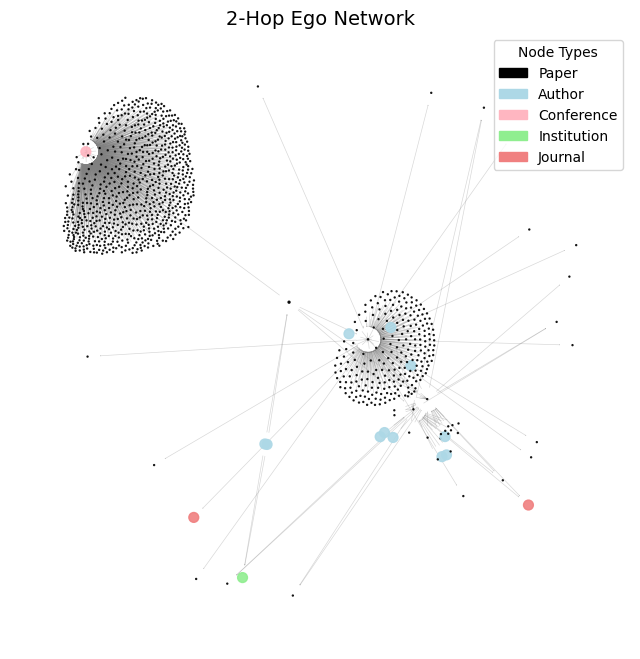

In [1228]:
# Visualize 2-hop network from a random paper
NODE_COLORS = {
    "author": "lightblue",
    "paper": "black",
    "institution": "lightgreen",
    "journal": "lightcoral",
    "conference": "lightpink",
    "unknown": "gray"
}


def visualize_2hop_network(data):
    """
    Creates a NetworkX visualization for a random node with 2-hop connections.

    Parameters:
    - data: JSON output from the ArangoDB AQL query.
    """
    G = nx.DiGraph()  # Create directed graph

    # Extract selected node (ego node)
    selected_node = data[0]["selected_node"]
    central_id = selected_node["_id"]
    central_label = selected_node.get("Author_Name", selected_node.get("PaperTitle", ""))
    central_type = selected_node.get("node_type", "unknown")
    central_color = NODE_COLORS.get(central_type, "gray")

    # Add selected node with label and color
    G.add_node(central_id, label=central_label, color=central_color, size=2)

    # Dictionary to store node types for legend
    node_type_legend = {central_type: central_color}

    # Process first-hop and second-hop connections
    for conn_list in [data[0]["first_hop_connections"], data[0]["second_hop_connections"]]:
        for conn in conn_list:
            node = conn["node"]
            edge = conn["edge"]

            node_id = node["_id"]
            node_type = node.get("node_type", "unknown")
            edge_type = edge["edge_type"]

            # Set node size: Papers = 0.5, Others = 10
            node_size = 0.5 if node_type == "paper" else 50

            # Add node and edge (skip self-loops)
            if node_id != central_id:
                G.add_node(node_id, label="", color=NODE_COLORS.get(node_type, "gray"), size=node_size)
                G.add_edge(edge["_from"], edge["_to"], label=edge_type)

                # Track node type for legend
                node_type_legend[node_type] = NODE_COLORS.get(node_type, "gray")

    # Draw the graph
    plt.figure(figsize=(8, 8))

    pos = nx.spring_layout(G, seed=42, k=0.1) # 42

    # Get node colors and sizes
    node_colors = [G.nodes[n]["color"] for n in G.nodes]
    # node_sizes = [G.nodes[n]["size"] * 100 for n in G.nodes]
    node_sizes = [G.nodes[n]["size"] for n in G.nodes]

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)

    # Draw edges with transparency (alpha=0.3)
    nx.draw_networkx_edges(G, pos, edge_color="gray", alpha=0.3, arrows=True, arrowsize=0.5, width=0.5)

    # Add legend for node types
    legend_patches = [mpatches.Patch(color=color, label=node_type.capitalize()) for node_type, color in node_type_legend.items()]
    plt.legend(handles=legend_patches, loc="upper right", fontsize=10, title="Node Types")

    # Show plot
    plt.title("2-Hop Ego Network", fontsize=14)
    plt.axis("off")
    plt.show()

# Call function
visualize_2hop_network(result_hops)

In [1525]:
# Count the number of nodes of each type
list(G_adb.query("""
FOR node IN graph_node
  COLLECT type = node.node_type WITH COUNT INTO count
  RETURN { "node_type": type, "count": count }
"""
))

[{'node_type': None, 'count': 2},
 {'node_type': 'author', 'count': 3278954},
 {'node_type': 'conference', 'count': 3937},
 {'node_type': 'institution', 'count': 15274},
 {'node_type': 'journal', 'count': 27919},
 {'node_type': 'paper', 'count': 2520475}]

In [11]:
# Create arango search view
db.create_arangosearch_view(name='graph_view')

# Define indexing configuration for 'graph_node' collection
link_config = {
    "includeAllFields": True,
    "fields": {
        "PaperTitle": { "analyzers": ["text_en"] },
        "Author_Name": { "analyzers": ["text_en"] },
        "Journal_Name": { "analyzers": ["text_en"] },
        "ConferenceSeries_Name": { "analyzers": ["text_en"] },
        "Affiliation_Name": { "analyzers": ["text_en"] }
    }
}

# Update the view to link it with the 'graph_node' collection
db.update_arangosearch_view(
    name='graph_view',
    properties={'links': {'graph_node': link_config}}
)


{'global_id': 'h9886F00512A8/609',
 'id': '609',
 'name': 'graph_view',
 'type': 'arangosearch',
 'cleanup_interval_step': 2,
 'commit_interval_msec': 1000,
 'consolidation_interval_msec': 1000,
 'consolidation_policy': {'type': 'tier',
  'segments_min': 1,
  'segments_max': 10,
  'segments_bytes_max': 5368709120,
  'segments_bytes_floor': 2097152,
  'min_score': 0},
 'primary_sort': [],
 'primary_sort_compression': 'lz4',
 'stored_values': [],
 'writebuffer_idle': 64,
 'writebuffer_active': 0,
 'writebuffer_max_size': 33554432,
 'links': {'graph_node': {'analyzers': ['identity'],
   'fields': {'Author_Name': {'analyzers': ['text_en']},
    'ConferenceSeries_Name': {'analyzers': ['text_en']},
    'Journal_Name': {'analyzers': ['text_en']},
    'PaperTitle': {'analyzers': ['text_en']},
    'Affiliation_Name': {'analyzers': ['text_en']}},
   'includeAllFields': True,
   'storeValues': 'none',
   'trackListPositions': False}}}

# Step 4. Defining LLM Agents

In [12]:
import os
from typing import Any, Dict, List, Optional, Tuple
from typing_extensions import TypedDict

from langchain.schema import HumanMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph
# from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
from pydantic import BaseModel, Field
from langgraph.pregel import RetryPolicy
import time
from langchain_core.messages import HumanMessage

In [13]:
# Graph State for LangGraph
class AcademicGraphState(TypedDict):

    messages: Optional[List[HumanMessage]] = None
    user_query: Optional[str] = None
    aql_task: Optional[str] = None
    nx_task: Optional[str] = None
    output_task: Optional[str] = None
    filtered_graph: Optional[Any] = None
    aql_output: Optional[List[Dict[str, Any]]] = None
    generated_aql_query: Optional[str] = None
    nx_output: Optional[Dict[str, Any]] = None
    final_answer: Optional[str] = None

### 1. Query Router

Query Router Agent that split the user's query into AQL subtask, NetworkX subtask, and output subtask.

In [14]:
class SubTaskSchema(BaseModel):
    aql_task: str = Field(..., description="A task to retrieve relevant data from ArangoDB graph.")
    nx_task: str = Field(..., description="A NetworkX task to perform on the retrieved graph.")
    output_task: str = Field(..., description="Final output processing task.")

In [15]:
def router_node(state: AcademicGraphState) -> Command[str]:
    """
    Splits the user's query into AQL subtask, Nx subtask, and output subtask,
    then returns them in the state.
    """

    # 1) Extract user query from messages or user_query
    if "messages" in state and state["messages"]:
        user_query = state["messages"][-1].content
    elif "user_query" in state:
        user_query = state["user_query"]
    else:
        raise ValueError("No valid user input found in state")

    # Ensure `user_query` is stored in state
    state["user_query"] = user_query

    # Call LLM to generate subqueries
    # llm_router = ChatOpenAI(model="gpt-4o", temperature=0)
    # llm_router = llm_router.bind_tools([SubQuerySchema])
    llm_router = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(SubTaskSchema)

    prompt_template = """Decompose the user query into three sub-tasks:
    1. AQL task: A task to retrieve relevant data from ArangoDB graph.
    2. NetworkX task: A NetworkX task to perform on the retrieved graph.
    3. Output task: Final output processing task.

    If the query doesn't have AQL task or NetworkX task, just return None for that task.
    If the query mention selecting top/bottom of papers/authors/etc. mention this in AQL or NetworkX task.

    Example 1:
      User query: "Plot communities of papers about transformers based on co-authors published in 2019"
      AQL task: "Find all papers about transformers published in 2019 and their authors"
      NetworkX task: "Find communities in this network"
      Output task: "Plot the network with community labels"

    Example 2:
      User query: "Show all authors affiliated with University of Bristol who published their papers in IEEE Transactions on Pattern Analysis and Machine Intelligence"
      AQL task: "Find all authors affiliated with University of Bristol who published their papers in IEEE Transactions on Pattern Analysis and Machine Intelligence and their names"
      NetworkX task: "None"
      Output task: "Print the names of authors"

    Example 3:
      User query: "user_query = "Show top-10 influential papers about transformers based on how many influential papers cite them (use pagerank)"
      AQL Task: "Find all papers about transformers and the papers that cite them"
      NetworkX Task: "Calculate PageRank to determine the influence of each paper and select top-10 papers"
      Output Task: "Print the paper titles in descending order of influence"

    User query: {user_query}
    """
    prompt = prompt_template.format(user_query=user_query)

    llm_response = llm_router.invoke(prompt)

    # Extract subtasks from structured response
    aql_task = llm_response.aql_task
    nx_task = llm_response.nx_task
    out_task = llm_response.output_task

    # To None
    if aql_task == "None":
        aql_task = None
    if nx_task == "None":
        nx_task = None

    print(f"\n\n>>> Query Decomposition:\n")
    print(f"User Query: {user_query}")
    print(f"AQL Task: {aql_task}")
    print(f"NetworkX Task: {nx_task}")
    print(f"Output Task: {out_task}")

    # 3) Update the state
    return Command(
        update={
            "user_query": user_query,
            "aql_task": aql_task,
            "nx_task": nx_task,
            "output_task": out_task,
        },
        goto="aql_executor",
    )

### 2. AQL Executor

AQL Executor Agent that generate and execute an AQL query on ArangoDB based on the sub-task.

In [16]:
# External prompt template
PROMPT_TEMPLATE_AQL = """
You are an expert in generating AQL queries for an academic graph.

Graph structure:
{graph_structure}

Example queries:
{examples}

Important:
- ALWAYS return data matching the original graph data structure with original attributes (_id, _key, node_type, etc.).
- Include full node and edge objects as shown in the examples.
- When searching documents by text relevance, use BM25 scoring and limit the results to relevant documents (typically BM25 score > 5).
- **ALWAYS filter papers to ensure they belong to the specified journal, conference, or filtering criteria.**
- **Ensure that citations are restricted only to papers that belong to the same journal, conference, or specified filter criteria.**
- **Do not return citations to papers outside the selected journal or filtering scope.**

Generate an AQL query for:
"{user_query}"

Only return the AQL query, no additional text or markdown.
"""

# Graph structure and examples
GRAPH_STRUCTURE_AQL = """
# Academic Graph Structure in ArangoDB

## Graph Schema
- Graph name: 'graph'
- Single vertex collection: 'graph_node'
- Single edge collection: 'graph_node_to_graph_node'

## Nodes
1. Papers: node_type="paper", attrs: PaperTitle, Year
2. Authors: node_type="author", attrs: Author_Name, H_index
3. Journals: node_type="journal", attrs: Journal_Name
4. Conferences: node_type="conference", attrs: ConferenceSeries_Name
5. Institutions: node_type="institution", attrs: Institution_Name, ISO_Code

## Edges
- Paper → Paper: edge_type="cites"
- Paper → Conference/Journal: edge_type="published_in"
- Author → Paper: edge_type="authored"
- Author → Institution: edge_type="affiliated_with"

## Notes
- Use named graph 'graph' for traversals
- Edge direction matters
"""

EXAMPLES_AQL = """
Example Queries:

Example 1:
User query: "Return a paper "Attention Is All You Need" and all its connections"
AQL query:
```
FOR paper IN graph_node
  FILTER paper.node_type == "paper" AND paper.PaperTitle == "Attention Is All You Need"

  LET citations = (
    FOR v, e IN 1..1 ANY paper GRAPH "graph"
      FILTER e.edge_type == "cites"
      RETURN {node: v, relationship: e, direction: e._from == paper._id ? "outgoing" : "incoming"}
  )

  LET authors = (
    FOR v, e IN 1..1 INBOUND paper GRAPH "graph"
      FILTER e.edge_type == "authored" AND v.node_type == "author"
      RETURN {node: v, relationship: e}
  )

  LET venue = (
    FOR v, e IN 1..1 OUTBOUND paper GRAPH "graph"
      FILTER e.edge_type == "published_in"
      RETURN {node: v, relationship: e, venue_type: v.node_type}
  )

  RETURN {paper, connections: {citations, authors, venue}}
```

Example 2 (Search using BM25):
User query: "Find papers about 'graph neural networks'"
AQL query:
```
FOR paper IN graph_view
  SEARCH ANALYZER(paper.PaperTitle IN TOKENS('graph neural networks', 'text_en'), 'text_en')
  LET score = BM25(paper)
  FILTER score > 5
  SORT score DESC
  RETURN paper
```

# Example 3:
User query: "Find all papers published at Journal of Computer Science and their citation network.
AQL query:
```
FOR journal IN graph_node
  FILTER journal.node_type == "journal"
  AND journal.Journal_Name == "Journal of Computer Science"

  FOR paper IN 1..1 INBOUND journal GRAPH "graph"
    FILTER paper.node_type == "paper"

    LET citations = (
      FOR v, e IN 1..1 ANY paper GRAPH "graph"
        FILTER e.edge_type == "cites"
        FILTER v.node_type == "paper"

        // Ensure the cited papers are also from the same journal
        FILTER LENGTH(
          FOR j IN 1..1 OUTBOUND v GRAPH "graph"
            FILTER j.node_type == "journal"
            FILTER j._id == journal._id
            RETURN j
        ) > 0

        RETURN {node: v, relationship: e, direction: e._from == paper._id ? "outgoing" : "incoming"}
    )

    RETURN {paper, citations}
```

"""


def generate_aql_query(user_query: str, api_key: Optional[str] = None) -> str:
    """
    Generates an AQL query for an academic graph database using an LLM via LangChain.

    Parameters:
    - user_query (str): The user's input query.
    - api_key (Optional[str]): OpenAI API key. If not provided, it is fetched from the environment variable.

    Returns:
    - str: The generated AQL query.
    """

    if api_key is None:
        api_key = os.environ.get("OPENAI_API_KEY")
        if api_key is None:
            raise ValueError("No API key provided. Set OPENAI_API_KEY environment variable or pass the key as a parameter.")

    # Initialize LLM via LangChain
    llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=api_key)

    # Prepare prompt
    prompt = PROMPT_TEMPLATE_AQL.format(
        graph_structure=GRAPH_STRUCTURE_AQL,
        examples=EXAMPLES_AQL,
        user_query=user_query
    )

    # Invoke LLM to generate AQL query
    response = llm.invoke(prompt)
    aql_query = response.content.strip()

    # Clean output (remove code block formatting if present)
    if aql_query.startswith("```aql"):
        aql_query = aql_query[6:]
    elif aql_query.startswith("```"):
        aql_query = aql_query[3:]

    if aql_query.endswith("```"):
        aql_query = aql_query[:-3]

    return aql_query.strip()



In [17]:
def aql_executor_node(state: AcademicGraphState) -> Command[str]:
    """
    Generate and execute an AQL query on ArangoDB.
    """
    generated_aql_query = generate_aql_query(state["aql_task"])
    print("\n\n>>> Generated AQL Query:\n")
    print(generated_aql_query)
    aql_output = list(G_adb.query(generated_aql_query))
    print("\n\n>>> Beggining of AQL Output:\n")
    print(aql_output[:2])
    # filtered_graph = build_graph_from_aql_output(aql_output)

    # Determine next node dynamically
    next_node = "nx_executor" if state["nx_task"] else "output_processor"

    return Command(
        update={"aql_output": aql_output,
                "generated_aql_query":generated_aql_query},
        goto=next_node
    )

### 3. NetworkX Executor

NetworkX Executor Agent that generate and execute an Python code using NetworkX algorithms based on the sub-task.

In [41]:
def build_graph_from_aql_output(aql_output: List[Dict[str, Any]]) -> nx.DiGraph:
    """
    Converts the AQL query output into a NetworkX directed graph.

    Args:
        aql_output: List of dictionaries from executing an AQL query.

    Returns:
        A NetworkX directed graph representing the query result.
    """

    G = nx.DiGraph()

    for record in aql_output:
        # Extract main nodes (e.g., paper, author, etc.) and connections
        for key, value in record.items():
            if isinstance(value, dict) and '_id' in value:
                node = value
                G.add_node(node['_id'], **node)

            elif isinstance(value, list):
                for connection in value:
                    connected_node = connection.get('node')
                    edge = connection.get('relationship')

                    if connected_node and '_id' in connected_node:
                        G.add_node(connected_node['_id'], **connected_node)

                    if edge and '_from' in edge and '_to' in edge:
                        G.add_edge(edge['_from'], edge['_to'], **edge)

    return G


def create_graph_overview(G):
    """
    Creates a comprehensive overview of a NetworkX graph structure including node types,
    edge types, and their attributes with examples.

    Args:
        G: NetworkX graph object

    Returns:
        A dictionary with the graph structure overview
    """
    # Initialize the overview dictionary
    overview = {
        "graph_info": {
            "is_directed": G.is_directed(),
            "num_nodes": G.number_of_nodes(),
            "num_edges": G.number_of_edges()
        },
        "node_types": {},
        "edge_types": {}
    }

    # Process nodes by type
    for node, data in G.nodes(data=True):
        node_type = data.get('node_type', 'unknown')

        # Initialize this node type if not seen before
        if node_type not in overview["node_types"]:
            overview["node_types"][node_type] = {
                "count": 0,
                "attributes": {},
                "examples": []
            }

        # Increment count for this node type
        overview["node_types"][node_type]["count"] += 1

        # Add to examples if we have fewer than 3
        if len(overview["node_types"][node_type]["examples"]) < 3:
            # Create a copy to avoid modifying the graph
            node_example = {k: v for k, v in data.items()}
            node_example["_id"] = node  # Add the node id
            overview["node_types"][node_type]["examples"].append(node_example)

        # Collect attribute information
        for attr, value in data.items():
            if attr not in overview["node_types"][node_type]["attributes"]:
                overview["node_types"][node_type]["attributes"][attr] = {
                    "type": type(value).__name__,
                    "examples": []
                }

            # Add example values if we have fewer than 5
            if len(overview["node_types"][node_type]["attributes"][attr]["examples"]) < 5:
                # Don't add duplicates
                example_value = str(value)[:50]  # Truncate long values
                if example_value not in overview["node_types"][node_type]["attributes"][attr]["examples"]:
                    overview["node_types"][node_type]["attributes"][attr]["examples"].append(example_value)

    # Process edges by type
    for u, v, data in G.edges(data=True):
        edge_type = data.get('edge_type', 'unknown')

        # Initialize this edge type if not seen before
        if edge_type not in overview["edge_types"]:
            overview["edge_types"][edge_type] = {
                "count": 0,
                "attributes": {},
                "connections": {},
                "examples": []
            }

        # Increment count for this edge type
        overview["edge_types"][edge_type]["count"] += 1

        # Add to examples if we have fewer than 3
        if len(overview["edge_types"][edge_type]["examples"]) < 3:
            # Create a copy to avoid modifying the graph
            edge_example = {k: v for k, v in data.items()}
            edge_example["source"] = u
            edge_example["target"] = v
            overview["edge_types"][edge_type]["examples"].append(edge_example)

        # Track connection types
        source_type = G.nodes.get(u, {}).get('node_type', 'unknown')
        target_type = G.nodes.get(v, {}).get('node_type', 'unknown')
        connection_key = f"{source_type}->{target_type}"

        if connection_key not in overview["edge_types"][edge_type]["connections"]:
            overview["edge_types"][edge_type]["connections"][connection_key] = 0
        overview["edge_types"][edge_type]["connections"][connection_key] += 1

        # Collect attribute information
        for attr, value in data.items():
            if attr not in overview["edge_types"][edge_type]["attributes"]:
                overview["edge_types"][edge_type]["attributes"][attr] = {
                    "type": type(value).__name__,
                    "examples": []
                }

            # Add example values if we have fewer than 5
            if len(overview["edge_types"][edge_type]["attributes"][attr]["examples"]) < 5:
                # Don't add duplicates
                example_value = str(value)[:50]  # Truncate long values
                if example_value not in overview["edge_types"][edge_type]["attributes"][attr]["examples"]:
                    overview["edge_types"][edge_type]["attributes"][attr]["examples"].append(example_value)

    return overview


def format_graph_overview_for_prompt(overview):
    """
    Formats the graph overview dictionary into a string suitable for inclusion in a prompt.

    Args:
        overview: Graph overview dictionary from create_graph_overview()

    Returns:
        A formatted string describing the graph structure
    """
    # Start with basic graph info
    lines = [
        "Graph Structure Overview:",
        f"- Directed: {overview['graph_info']['is_directed']}",
        f"- Nodes: {overview['graph_info']['num_nodes']}",
        f"- Edges: {overview['graph_info']['num_edges']}",
        ""
    ]

    # Add node type information
    lines.append("Node Types:")
    for node_type, info in overview["node_types"].items():
        lines.append(f"- {node_type} ({info['count']} nodes) with attributes:")

        # Add attribute details
        for attr, attr_info in info["attributes"].items():
            examples_str = ", ".join(attr_info["examples"])
            if len(examples_str) > 100:
                examples_str = examples_str[:100] + "..."
            lines.append(f"  * {attr} ({attr_info['type']}): {examples_str}")

    lines.append("")

    # Add edge type information
    lines.append("Edge Types:")
    for edge_type, info in overview["edge_types"].items():
        lines.append(f"- {edge_type} ({info['count']} edges) with attributes:")

        # Add attribute details
        for attr, attr_info in info["attributes"].items():
            examples_str = ", ".join(attr_info["examples"])
            if len(examples_str) > 100:
                examples_str = examples_str[:100] + "..."
            lines.append(f"  * {attr} ({attr_info['type']}): {examples_str}")

        # Add connection types
        conn_lines = []
        for conn, count in info["connections"].items():
            conn_lines.append(f"{conn} ({count})")
        lines.append(f"  * Connections: {', '.join(conn_lines)}")

    return "\n".join(lines)


def get_networkx_output(G, user_query: str, api_key: Optional[str] = None):
    """
    Answers natural language questions about a NetworkX graph.

    Args:
        G: NetworkX graph object
        user_query: A natural language query about the graph
        api_key: OpenAI API key (if not provided, will try to use environment variable)

    Returns:
        A natural language answer to the user's query
    """
    # Use environment variable if API key not provided
    if api_key is None:
        api_key = os.environ.get("OPENAI_API_KEY")
        if api_key is None:
            raise ValueError("No API key provided. Set OPENAI_API_KEY environment variable or pass the key as a parameter.")

    # Step 1: Generate NetworkX code to answer the query
    code = generate_networkx_code(G, user_query, api_key)
    print("\n\n >>> Python Code using NetworkX:\n")
    print(code)

    # Step 2: Execute the code to get the result
    result = execute_networkx_code(G, code)
    # print(result)

    dict_output = {
        "user_query": user_query,
        "code": code,
        "result": result
    }

    return dict_output

def execute_networkx_code(G, code: str):
    """Execute the generated NetworkX code and return the result"""
    global_vars = {"G": G, "nx": nx}
    local_vars = {}

    # Check if code redefines G, and prevent it if needed
    if "G = nx." in code:
        code_lines = code.split("\n")
        filtered_lines = [line for line in code_lines if not line.strip().startswith("G = nx.")]
        code = "\n".join(filtered_lines)

    try:
        exec(code, global_vars, local_vars)
        if "FINAL_RESULT" not in local_vars:
            return "Error: Code did not produce a FINAL_RESULT variable."
        return local_vars["FINAL_RESULT"]
    except Exception as e:
        # Try to make a more robust version for this specific question
        print(e)
        return None


def generate_networkx_code(G, user_query: str, api_key: Optional[str] = None) -> str:
    """
    Generates Python code using NetworkX to analyze the graph and answer the query.

    Parameters:
    - G: NetworkX graph object.
    - user_query (str): The user's input query.
    - api_key (Optional[str]): OpenAI API key. If not provided, it is fetched from the environment variable.

    Returns:
    - str: The generated Python code.
    """

    if api_key is None:
        api_key = os.environ.get("OPENAI_API_KEY")
        if api_key is None:
            raise ValueError("No API key provided. Set OPENAI_API_KEY environment variable or pass the key as a parameter.")

    # Initialize LLM via LangChain
    llm = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key=api_key)

    # Get graph overview
    overview = create_graph_overview(G)
    graph_description = format_graph_overview_for_prompt(overview)

    # Additional instructions to guide the model's interpretation
    concept_mapping = """
    Interpret the following terms correctly when analyzing the graph:
    - "Influential nodes" -> Use PageRank unless otherwise specified.
    - "Most connected nodes" or "highly connected nodes" -> Use Degree Centrality.
    - "Tightly connected groups" or "clusters" or "communities" -> Use Community Detection.
    - "Bridging nodes" or "important intermediaries" -> Use Betweenness Centrality.
    """

    # Construct prompt
    prompt = f"""You are an expert in network analysis using NetworkX.

    {graph_description}

    I want to answer this question about the graph: \"{user_query}\"

    Generate Python code using NetworkX that will answer this query. The graph object is named 'G'.

    {concept_mapping}

    Important instructions:
    1. Use only standard NetworkX functions and basic Python.
    2. Store the final result in a dictionary called FINAL_RESULT structured exactly as follows:

    {{
        \"description\": \"<A clear description of the analysis performed>\",
        \"result\": {{
            \"node_id\": {{\"value\": <numeric_value>, \"name\": <name_of_entity_if_available>}},
            ...
        }} OR if single numeric value: {{\"result\": value}},
        \"graph\": G
    }}

    3. If nodes represent papers or authors, include their names in the 'name' field using attributes like 'PaperTitle' or 'Author_Name'.
    4. Be precise about which NetworkX algorithms you select.
    5. Think step-by-step to solve the problem.
    6. Only return the Python code with no explanations.
    7. Do not include markdown code blocks.
    8. DO NOT redefine G or create a new graph – use the existing graph G.
    9. Make sure your code is complete – define all variables before using them.
    10. If performing community detection, convert G to a standard NetworkX graph first: `G = G.to_networkx_class()`
    11. Use asynchronous label propagation (LPA) for community detection when applicable.
    12. If an algorithm produces numerical results per node, format them as follows:

    Example 1 - Community Detection:
    {{
        \"description\": \"Community ID for each paper node\",
        \"result\": {{
            \"paper_node_1\": {{\"value\": 1, \"name\": \"Attention is All You Need\"}},
            \"paper_node_2\": {{\"value\": 2, \"name\": \"BERT: Pre-training of Deep Bidirectional Transformers\"}}
        }},
        \"graph\": G
    }}

    Example 2 - Degree Centrality:
    {{
        \"description\": \"Degree centrality of each author\",
        \"result\": {{
            \"author_node_1\": {{\"value\": 0.75, \"name\": \"Geoffrey Hinton\"}},
            \"author_node_2\": {{\"value\": 0.62, \"name\": \"Yoshua Bengio\"}}
        }},
        \"graph\": G
    }}

    Example 3 - Global Network Metric:
    {{
        \"description\": \"Average clustering coefficient of the graph\",
        \"result\": {{\"result\": 0.43}},
        \"graph\": G
    }}
    """

    # Invoke LLM to generate NetworkX code
    response = llm.invoke(prompt)
    code = response.content.strip()

    # Remove markdown code blocks if present
    if code.startswith("python"):
        code = code[10:]
    elif code.startswith("```"):
        code = code[3:]

    if code.endswith("```"):
        code = code[:-3]

    return code.strip()

In [42]:
def nx_executor_node(state: AcademicGraphState) -> Command[str]:
    """
    Perform Nx-based analysis (community detection, etc.) on the subgraph.
    """

    filtered_graph = build_graph_from_aql_output(state['aql_output'])
    print(f"\n\n>>> Create NetworkX Graph with {len(filtered_graph.nodes)} nodes and {len(filtered_graph.edges)} edges\n")

    nx_task = state["nx_task"]

    nx_output = get_networkx_output(filtered_graph, nx_task)

    return Command(
        update={"nx_output": nx_output,
                "filtered_graph":filtered_graph},
        goto="output_processor"
    )

### 4. Output Processor

Output Processor that given the output from AQL or NetworkX Executor generate output in text or visual format depending on the user's query.

In [43]:
class CommunityName(BaseModel):
    community_id: int
    community_name: str
    paper_count: int  # Number of papers in the community


def generate_community_labels(community_dict: Dict[str, Dict[str, str]]) -> List[CommunityName]:
    """
    Generate concise and descriptive names (max 4-5 words) for the top-10 largest communities based on paper titles.

    Parameters:
    - community_dict: Dictionary where keys are node IDs and values are dictionaries with:
      {"value": community_id, "name": paper_title}

    Returns:
    - A list of `CommunityName` objects for the top-10 largest communities with their paper counts.
    """

    llm = ChatOpenAI(model="gpt-4o", temperature=0, seed=42)
    community_labels = []

    # Count the number of papers in each community
    community_sizes = Counter(data["value"] for data in community_dict.values())

    # Select the top-10 largest communities
    top_10_communities = community_sizes.most_common(20)  # [(community_id, size), ...]

    # Group paper titles for only the top-10 largest communities
    filtered_communities = {c_id: [] for c_id, _ in top_10_communities}
    for node_id, data in community_dict.items():
        community_id = data["value"]
        if community_id in filtered_communities:
            filtered_communities[community_id].append(data["name"])

    # Generate names for each of the top-10 largest communities
    for community_id, titles in filtered_communities.items():
        prompt = f"""
            Provide a concise and descriptive name (no more than 3-4 words) for the following research papers:\n
            {titles[:10]}\n
            The name should reflect the common theme of these papers.\n
            Avoid vague words like Advances, Recent Trends, or Latest Research.\n
            The name should be precise and reflect the shared focus of these papers.\n
            Don't use quotation marks in the name.
            """

        completion = llm.invoke(prompt)
        community_labels.append(
            CommunityName(
                community_id=community_id,
                community_name=completion.content.strip(),
                paper_count=len(titles)  # Number of papers in this community
            )
        )

    return community_labels


def plot_communities(dict_output, community_labels):
    """
    Plot a subgraph with nodes colored based on the communities provided in `community_labels`.

    Parameters:
    - dict_output: Dictionary containing 'graph' (NetworkX graph) and 'result' (community assignments).
    - community_labels: List of CommunityName objects containing community_id, community_name, and paper_count.
    """
    G = dict_output["graph"]
    node_results = dict_output["result"]["result"]  # Extract actual node data

    # Extract selected community IDs
    selected_community_ids = {c.community_id for c in community_labels}

    # Filter nodes that belong to selected communities
    filtered_nodes = {node_id for node_id, data in node_results.items() if data["value"] in selected_community_ids}

    # Ensure edges are also preserved (only keep edges where both nodes are in filtered_nodes)
    G_filtered = G.edge_subgraph((u, v) for u, v in G.edges() if u in filtered_nodes and v in filtered_nodes).copy()

    if not G_filtered.edges:
        print("Warning: No edges remain after filtering by selected communities.")

    if not G_filtered.nodes:
        print("Error: No nodes remain after filtering by selected communities.")
        return

    # Compute node positions
    pos = nx.spring_layout(G_filtered, k=0.1, seed=42)  # Adjusted for better spacing

    # Assign colors to selected communities
    unique_communities = sorted(selected_community_ids)  # Unique community IDs
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_communities)))  # Generate distinct colors
    color_map = {c.community_id: color for c, color in zip(community_labels, colors)}

    # Prepare color mapping for nodes
    node_colors = [color_map[node_results[n]["value"]] for n in G_filtered.nodes()]

    # Create figure
    plt.figure(figsize=(12, 10))

    # Draw nodes
    nx.draw_networkx_nodes(G_filtered, pos,
                            node_color=node_colors,
                            node_size=10)  # Outline for better visibility

    # Draw graph with edges
    nx.draw_networkx_edges(G_filtered, pos, alpha=0.5, edge_color="lightgray", width=0.5, arrowsize=0.5)  # Ensure edges remain visible

    # Create legend for selected communities
    community_name_dict = {c.community_id: c.community_name for c in community_labels}
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markersize=10,
                                  markerfacecolor=color_map[c.community_id], label=f"{c.community_name} ({c.paper_count})")
                      for c in community_labels]

    plt.legend(handles=legend_patches, loc="upper right", fontsize=6, title="Communities")

    # Plot title
    plt.title("Citation Communities of Papers", fontsize=14)
    plt.axis("off")
    plt.show()

In [44]:
# Define classification schema
class PlotCommunityDetection(BaseModel):
    is_plot_community: bool

# LLM function to classify output task
def classify_output_task(output_task: str) -> bool:
    """
    Uses an LLM to classify whether the output task involves plotting community detection.
    """
    llm = ChatOpenAI(model="gpt-4o", temperature=0, seed=42).with_structured_output(PlotCommunityDetection)

    prompt = f"""
    Determine if the following output task involves plotting a community detection graph.

    Task: "{output_task}"

    Answer with True if it involves plotting community structures, and False otherwise.
    """

    response = llm.invoke(prompt)
    return response.is_plot_community

# Updated output processor function
def output_processor_node(state: AcademicGraphState) -> Command[str]:
    """
    Generate the final output based on the available data in the state.

    1) If `aql_task` exists but no `nx_task`, summarize `aql_output` using LLM.
    2) If `nx_task` exists but the output task is not about plotting communities, summarize `nx_output`.
    3) If `nx_task` exists and the output task is about plotting community detection, generate a network plot.
    """

    llm_summary = ChatOpenAI(model="gpt-4o", temperature=0, seed=42)

    if state.get("aql_task") and not state.get("nx_task"):
        # Case 1: Summarize AQL output
        prompt = f"""
        Given the following user query: {state['user_query']}
        and AQL output: {state['aql_output'][:30]}, generate a concise summary based on this task: {state['output_task']}.
        """
        summary = llm_summary.invoke(prompt).content.strip()
        return Command(update={"final_answer": summary}, goto=END)

    elif state.get("nx_task") and not classify_output_task(state["output_task"]):
        # Case 2: Summarize Nx output if no plotting is requested
        prompt = f"""
        Given the following user query: {state['user_query']}
        and NetworkX output: {state['nx_output']}, generate a concise summary based on this task: {state['output_task']}.
        """
        summary = llm_summary.invoke(prompt).content.strip()
        return Command(update={"final_answer": summary}, goto=END)

    elif state.get("nx_task") and classify_output_task(state["output_task"]):
        # Case 3: Generate community detection plot
        dict_output = {
            "graph": state["filtered_graph"],
            "result": state["nx_output"]['result']
        }
        community_labels = generate_community_labels(state['nx_output']['result']['result'])
        plot_communities(dict_output, community_labels)

        return Command(update={"final_answer": "Graph visualization generated."}, goto=END)

    else:
        return Command(update={"final_answer": "No output generated."}, goto=END)

### 5. Workflow

Combines distinct LLM agents into a structured LangGraph workflow.

In [45]:
def build_multi_agent_graph():

    workflow = StateGraph(AcademicGraphState)

    # Register each node
    workflow.add_node("router", router_node, retry=RetryPolicy())
    workflow.add_node("aql_executor", aql_executor_node, retry=RetryPolicy())
    workflow.add_node("nx_executor", nx_executor_node, retry=RetryPolicy())
    workflow.add_node("output_processor", output_processor_node, retry=RetryPolicy())

    # Start with router
    workflow.add_edge(START, "router")
    # The rest of the graph is dynamic

    return workflow.compile()

In [46]:
def process_user_query(user_query, llm_graph, max_retries=3):
    """
    Process a user query using an LLM graph with retry logic.

    Parameters:
    - user_query: The input query string.
    - llm_graph: The LangGraph pipeline to invoke.
    - max_retries: Maximum number of retry attempts (default=3).

    Returns:
    - final_state: The final state of the LangGraph execution.
    """

    inputs = {"messages": [HumanMessage(content=user_query)]}

    for attempt in range(max_retries):
        try:
            final_state = llm_graph.invoke(inputs)

            # Print the final answer as markdown
            print("\n\n>>> Final Answer:\n")
            display(Markdown(final_state['final_answer']))

            return final_state  # Successful execution, return the result

        except (KeyError, ConnectionError, TimeoutError) as e:
            print(f"Attempt {attempt + 1} failed: {str(e)}")

            if attempt < max_retries - 1:
                wait_time = 2 ** attempt  # Exponential backoff
                print(f"Retrying in {wait_time} seconds...\n")
                time.sleep(wait_time)
            else:
                print("Maximum retries reached. Failed to process query.")
                return {"error": "Failed to generate response after multiple attempts."}

# Step 5. Use Cases of the Multi-Agent System

In [47]:
from collections import Counter

In [48]:
llm_graph = build_multi_agent_graph()

## 1. Filtering Authors by Affiliation and Publication History

In [49]:
user_query = "Show all authors affiliated with University of Bristol who published their papers in IEEE Transactions on Pattern Analysis and Machine Intelligence"
final_state = process_user_query(user_query, llm_graph)



>>> Query Decomposition:

User Query: Show all authors affiliated with University of Bristol who published their papers in IEEE Transactions on Pattern Analysis and Machine Intelligence
AQL Task: Find all authors affiliated with University of Bristol who published their papers in IEEE Transactions on Pattern Analysis and Machine Intelligence and their names
NetworkX Task: None
Output Task: Print the names of authors


>>> Generated AQL Query:

FOR institution IN graph_node
  FILTER institution.node_type == "institution" 
  AND institution.Institution_Name == "University of Bristol"

  FOR author IN 1..1 INBOUND institution GRAPH "graph"
    FILTER author.node_type == "author"

    FOR paper IN 1..1 OUTBOUND author GRAPH "graph"
      FILTER paper.node_type == "paper"

      FOR journal IN 1..1 OUTBOUND paper GRAPH "graph"
        FILTER journal.node_type == "journal"
        AND journal.Journal_Name == "IEEE Transactions on Pattern Analysis and Machine Intelligence"

        RETURN D

The authors affiliated with the University of Bristol who published their papers in IEEE Transactions on Pattern Analysis and Machine Intelligence are:

1. Will Price
2. Hazel Doughty
3. Jonathan Munro
4. Kaiyang Zhou
5. Michael Wray
6. Evangelos Kazakos
7. Davide Moltisanti
8. Xie Xianghua
9. S. Zhang
10. Toby Perrett
11. Majid Mirmehdi
12. Dima Damen
13. Osian Haines
14. Andrew Calway
15. Kai Han
16. Peng Li
17. Jian Li
18. C. Alejandro Parraga
19. Hongping Cai
20. Ioannis Pitas
21. Yiming Ying
22. Kaizhu Huang
23. Robert G. Aykroyd
24. Ian T. Nabney
25. Xianghua Xie

## 2. Identifying Most Influential Papers in a Domain

In [50]:
user_query = "Show titles of top-10 influential papers about recommendation systems"
final_state = process_user_query(user_query, llm_graph)



>>> Query Decomposition:

User Query: Show titles of top-10 influential papers about recommendation systems
AQL Task: Find all papers about recommendation systems and the papers that cite them
NetworkX Task: Calculate PageRank to determine the influence of each paper and select top-10 papers
Output Task: Print the paper titles in descending order of influence


>>> Generated AQL Query:

FOR paper IN graph_view
  SEARCH ANALYZER(paper.PaperTitle IN TOKENS('recommendation systems', 'text_en'), 'text_en')
  LET score = BM25(paper)
  FILTER score > 5
  SORT score DESC

  LET citing_papers = (
    FOR v, e IN 1..1 INBOUND paper GRAPH "graph"
      FILTER e.edge_type == "cites"
      FILTER v.node_type == "paper"
      RETURN {node: v, relationship: e}
  )

  RETURN {paper, citing_papers}


>>> Beggining of AQL Output:

[{'paper': {'_key': '1572314', '_id': 'graph_node/1572314', '_rev': '_jV4ZG06--p', 'node_type': 'paper', 'PaperTitle': 'Recommender Systems: Collaborative recommendation', 

Here are the titles of the top 10 influential papers about recommendation systems, listed in descending order of influence:

1. Matrix Factorization Techniques for Recommender Systems
2. Major components of the gravity recommendation system
3. Social Choice Theory and Recommender Systems: Analysis of the Axiomatic Foundations of Collaborative Filtering
4. Probabilistic Models for Unified Collaborative and Content-Based Recommendation in Sparse-Data Environments
5. Collaborative Deep Learning for Recommender Systems
6. Deep content-based music recommendation
7. Practical recommendations for gradient-based training of deep architectures
8. Content-boosted collaborative filtering for improved recommendations
9. Methods and metrics for cold-start recommendations
10. Naïve filterbots for robust cold-start recommendations

## 3. Mapping Citation-Based Communities



>>> Query Decomposition:

User Query: Plot network communities of papers about recommendation systems based on citations published after 2017
AQL Task: Find all papers about recommendation systems published after 2017 and the papers that cite them
NetworkX Task: Find communities in this citation network
Output Task: Plot the network with community labels


>>> Generated AQL Query:

FOR paper IN graph_view
  SEARCH ANALYZER(paper.PaperTitle IN TOKENS('recommendation systems', 'text_en'), 'text_en')
  FILTER paper.node_type == "paper" AND paper.Year > 2017
  LET score = BM25(paper)
  FILTER score > 5

  LET citations = (
    FOR v, e IN 1..1 INBOUND paper GRAPH "graph"
      FILTER e.edge_type == "cites" AND v.node_type == "paper"
      RETURN {node: v, relationship: e, direction: "incoming"}
  )

  RETURN {paper, citations}


>>> Beggining of AQL Output:

[{'paper': {'_key': '2488586', '_id': 'graph_node/2488586', '_rev': '_jV4Zrgq-_B', 'node_type': 'paper', 'PaperTitle': 'Automated S

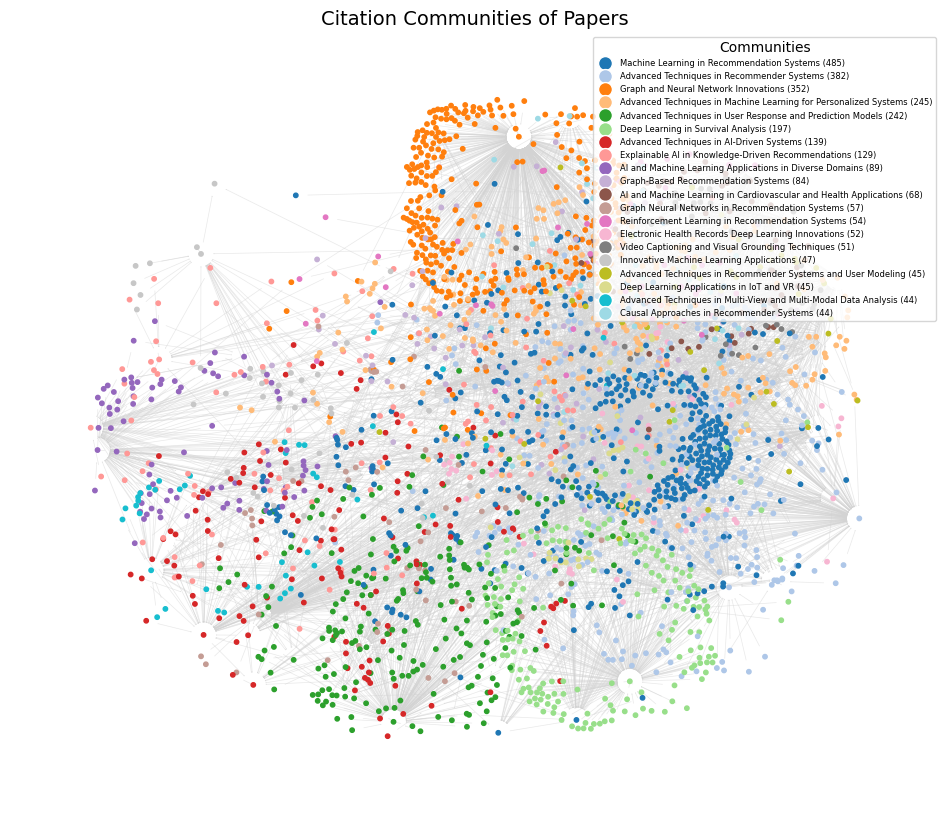



>>> Final Answer:



Graph visualization generated.

In [51]:
user_query = "Plot network communities of papers about recommendation systems based on citations published after 2017"
final_state = process_user_query(user_query, llm_graph)

# Conclusion

This notebook demonstrates the successful integration of a multi-agent workflow by:

1.	Utilizing ArangoDB for efficient storage and querying of complex entity relationships using AQL and SearchView.
2.	Employing NetworkX with CUDA to enable high-performance network analysis on large-scale graphs.
3.	Integrating LLMs with LangChain and LangGraph to dynamically translate user queries into AQL and NetworkX operations, simplifying data retrieval and analysis.